In [7]:

dir = '/home/liu/mysoft/pycharm/project/QuantistStudio/' \
       'MyTest/test_pytorch/data/name_data'

In [10]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles(dir + '/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(dir + '/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/home/liu/mysoft/pycharm/project/QuantistStudio/MyTest/test_pytorch/data/name_data/names/English.txt', '/home/liu/mysoft/pycharm/project/QuantistStudio/MyTest/test_pytorch/data/name_data/names/Italian.txt', '/home/liu/mysoft/pycharm/project/QuantistStudio/MyTest/test_pytorch/data/name_data/names/Japanese.txt', '/home/liu/mysoft/pycharm/project/QuantistStudio/MyTest/test_pytorch/data/name_data/names/Polish.txt', '/home/liu/mysoft/pycharm/project/QuantistStudio/MyTest/test_pytorch/data/name_data/names/Arabic.txt', '/home/liu/mysoft/pycharm/project/QuantistStudio/MyTest/test_pytorch/data/name_data/names/Dutch.txt', '/home/liu/mysoft/pycharm/project/QuantistStudio/MyTest/test_pytorch/data/name_data/names/Vietnamese.txt', '/home/liu/mysoft/pycharm/project/QuantistStudio/MyTest/test_pytorch/data/name_data/names/Korean.txt', '/home/liu/mysoft/pycharm/project/QuantistStudio/MyTest/test_pytorch/data/name_data/names/Greek.txt', '/home/liu/mysoft/pycharm/project/QuantistStudio/MyTest/test_pytor

In [13]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [14]:
# Turning Names into Tensors

import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

torch.Size([5, 1, 57])


In [15]:
# Creating the Network

import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [16]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input, hidden)

In [17]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.8736 -2.9766 -2.8393 -2.8506 -2.9167 -2.9992 -2.9319 -2.9158 -2.9639 -2.8575

Columns 10 to 17 
-2.9814 -2.9225 -2.8338 -2.8611 -2.8819 -2.8001 -2.9141 -2.7452
[torch.FloatTensor of size 1x18]



In [18]:
# Training

# Preparing for Training
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 17)


In [19]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Roach
category = Czech / line = Urbanek
category = Greek / line = Sotiris
category = English / line = Grenard
category = Polish / line = Piatek
category = Portuguese / line = Basurto
category = Japanese / line = Namiki
category = Italian / line = Belmonte
category = English / line = Longley
category = Dutch / line = Alst


In [20]:
# Training the Network

criterion = nn.NLLLoss()

In [21]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

In [22]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 28s) 2.1270 Maryanov / Polish ✗ (Russian)


10000 10% (0m 57s) 3.0216 Genji / Italian ✗ (Japanese)


15000 15% (1m 30s) 0.6080 Gomatos / Greek ✓


20000 20% (2m 1s) 3.4344 Close / English ✗ (Greek)


25000 25% (2m 31s) 0.6662 Bicchieri / Italian ✓


30000 30% (3m 1s) 1.7090 Milne / Scottish ✓


35000 35% (3m 31s) 2.7645 Adsit / Scottish ✗ (Czech)


40000 40% (3m 59s) 2.1054 Page / Japanese ✗ (French)


45000 45% (4m 28s) 3.7539 Laar / Arabic ✗ (Dutch)


50000 50% (4m 57s) 0.0180 Callaghan / Irish ✓


55000 55% (5m 25s) 1.1441 Kang / Korean ✓


60000 60% (5m 54s) 0.4973 Bradan / Irish ✓


65000 65% (6m 21s) 1.8156 Beek / Polish ✗ (Dutch)


70000 70% (6m 52s) 0.2677 Nesgovorov / Russian ✓


75000 75% (7m 21s) 0.5246 Russell / Scottish ✓


80000 80% (7m 51s) 0.0535 Agelakos / Greek ✓


85000 85% (8m 22s) 1.3357 Chun / Chinese ✗ (Korean)


90000 90% (8m 50s) 2.7419 Smith / Scottish ✗ (Czech)


95000 95% (9m 20s) 2.1874 Capello / Spanish ✗ (Italian)


100000 100% (9m 50s) 1.4048 Sabbagh / Arabic ✓


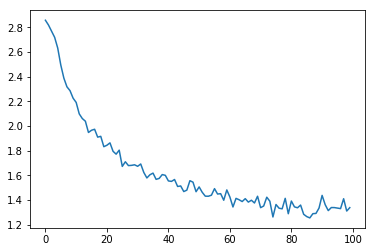

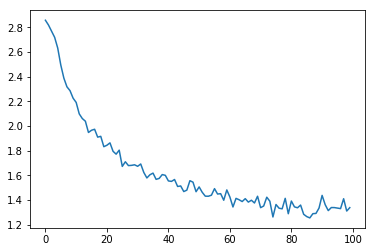

In [24]:
# Plotting the Results

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

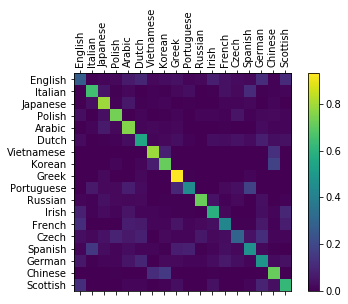

In [25]:
# Evaluating the Results

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [26]:
# Running on User Input

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.50) Russian
(-1.43) Czech
(-2.78) English

> Jackson
(-0.82) Scottish
(-1.09) English
(-2.48) Russian

> Satoshi
(-0.66) Arabic
(-1.20) Japanese
(-2.83) Polish
